In [441]:
%autosave 60
import matplotlib.pyplot as plt
import numpy as np
from nexusformat.nexus import nxload
from pathlib import Path
import datetime


class Nexus_handling:
    def get_nexus_data_I06(self,file):
        """Function that loads the data from a nexus file and returns it as a list of numpy
arrays"""
        entry_string = "entry"
        data_region_list = []
        metadata_region_list = None
        x_array = file[entry_string]["instrument"]["fastEnergy"]["value"].nxvalue
        y_array = file[entry_string]["instrument"]["fesData"]["C1"].nxvalue
        data_region_list.append({"x": x_array, "y": y_array})
        y_array = file[entry_string]["instrument"]["fesData"]["C5"].nxvalue
        data_region_list.append({"x": x_array, "y": y_array})
        y_array = file[entry_string]["instrument"]["fesData"]["idio"].nxvalue
        data_region_list.append({"x": x_array, "y": y_array})
        y_array = file[entry_string]["instrument"]["fesData"]["ifiofb"].nxvalue
        data_region_list.append({"x": x_array, "y": y_array})
        magnet_field = file[entry_string]["instrument"]["scm"]["field_z"].nxvalue
        metadata_region_list = {"magnet_ﬁeld": magnet_field}
        polar = file[entry_string]["instrument"]["id"]["polarisation"].nxvalue
        metadata_region_list["polarisation"] = polar
        ###Add temperature values here
        ### Add angle of the beam here => 
        return data_region_list, metadata_region_list

    def open_single_spectra(self,ﬁle_number,directory_path,ﬁle_preﬁx,sensor):
        ﬁle_name = directory_path + ﬁle_preﬁx + str(ﬁle_number) + ".nxs"
        spectra_ﬁle = nxload(ﬁle_name)
        data,meta_data = self.get_nexus_data_I06(spectra_ﬁle)
        if sensor == "TEY":
            spectra = {"x" : data[2]["x"],"y":data[2]["y"],"meta" : meta_data}
        elif sensor == "TFY":
            spectra = {"x" : data[3]["x"],"y":data[3]["y"],"meta" : meta_data}
        return spectra

class XMCD_data_analysis(Nexus_handling):
    def __init__(self):
        self.on_oI_edge_points = [571, 576.9]
        self.directory_path = None
        self.ﬁle_preﬁx = None
        self.energy = None
        self.spectra = []
        self.hyst = []
        self.XMCD = []
        self.magz = []
        #self.temperature
   

    def set_directory_path(self, directory_path):
        self.directory_path = directory_path

    def set_ﬁle_preﬁx(self, ﬁle_preﬁx):
        self.ﬁle_preﬁx = ﬁle_preﬁx

    def load_spectra(self, directory_path, ﬁle_preﬁx, XMCD_spectra_Set,sensor = "TEY"):  
        self.directory_path = directory_path
        self.ﬁle_preﬁx = ﬁle_preﬁx

        if len(XMCD_spectra_Set) != 1:
            for ﬁle_number in XMCD_spectra_Set: 
                print(file_number)
                data_set = self.open_single_spectra(ﬁle_number, directory_path,  ﬁle_preﬁx,sensor)
                self.spectra.append(data_set)
                self.energy = self.spectra[0]["x"]
        else:
            print(XMCD_spectra_Set)
            data_set = self.open_single_spectra(XMCD_spectra_Set[0], directory_path,  ﬁle_preﬁx,sensor)
            self.spectra.append(data_set)
    
            self.energy = self.spectra[0]["x"]
#######################################################################################
    ### Plotting functions
    
    def plot_spectra(self,XAS_file_Set,i, bounds = None, normalisation = None):
        #Plots a single XAS spectra out of a set 
        #XAS_file_set : a set of XAS scan numbers
        #i : the indice of which scan you want to plot
        Energy,Idio = XMCD.spectra[i]["x"],XMCD.spectra[i]["y"]
        if bounds is not None:
            plt.xlim(bounds[0])
            plt.ylim(bounds[1])

        if normalisation is not None:
            value = np.mean(Idio[:normalisation])
            plotting_y = Idio - value
            plotting_y = plotting_y / np.max(plotting_y) 
        else:
            plotting_y = Idio


        plt.plot(Energy,plotting_y,label = XAS_file_Set[i])
        plt.title(("XAS ",sensor,XAS_file_set[i],self.spectra[i]["meta"]["polarisation"]))
        plt.legend()
        plt.xlabel("Energy(eV)")
        plt.ylabel("idio")   

    def Dichroism(self,XMCD_ﬁle_Set, normalisation = None, avg = "Before"):
        #Takes in a series of XAS spectra of opposing polarisations then averages all the nc and all the pc and subtracts them to give us the dichroism
        # XMCD_file_Set : list of XAS spectra, at a minimum we need one of each polarisation of light.
        fig = plt.figure(figsize=(12, 6))
        ax = fig.subplots(1,3, sharey=True)  # (nrows, ncols, index)
        
        nc_storage = np.zeros(len(self.energy))
        pc_storage = np.zeros(len(self.energy))
        
        B_Field = self.spectra[0]["meta"]["magnet_ﬁeld"]
        fig.suptitle("Dichroism at " + str(np.round(B_Field,2)) +  "T ")
        print("B Field - ",B_Field)
        ax[0].set_title("pc")
        ax[1].set_title("nc")
        ax[2].set_title("XMCD")
        
        ax[1].set_xlabel("energy (eV")
        ax[0].set_ylabel("idio")
        
        n,m = 0,0
        max_point = 0

        
        for i in range(0,len(XMCD_file_Set)):
            Polarisation = self.spectra[i]["meta"]["polarisation"]
            F = self.spectra[i]["y"]

            if normalisation is not None:
                value = np.mean(F[:normalisation])
                F -= value

            
            f=np.polyfit(self.energy, F, 1)

            fit=np.polyval(f,self.energy)
            mx = np.max((F-fit)+0.1)
            if mx > max_point:
                max_point = mx
            if Polarisation == "nc":
                nc_storage += F
                n += 1
                ax[0].plot(self.energy,F, label = XMCD_file_Set[i] )
                ax[0].legend()

            elif Polarisation == "pc":
                pc_storage = pc_storage + F
                m = m + 1
                ax[1].plot(self.energy,F,label = XMCD_file_Set[i] )
                ax[1].legend()

        if avg == "Before":
            nc_storage = nc_storage/n
            pc_storage = pc_storage/m
            dichroism = abs(pc_storage) - abs(nc_storage)

            max_dichroism = np.max(dichroism)
            percentage = max_dichroism/max_point
            print(f"Max Di - {max_dichroism}, Max Signal - {max_point}")
        
        ax[2].plot(self.energy,dichroism,label = f"XMCD - {np.round(percentage,3)}%")
        ax[2].legend()

        for axs in ax:
            axs.axhline(y = 0, color = 'b', linestyle = 'dashed') 
            # axs.set_ylim(-0.05, 1)
        return self.energy,dichroism                    

def prelimenary_code(directory_path, ﬁle_preﬁx, XAS_ﬁle_set,sensor):
    XMCD = XMCD_data_analysis()
    XMCD.load_spectra(directory_path, ﬁle_preﬁx, XAS_ﬁle_set,sensor)
    return XMCD

def get_values(file):
    
    nexus = nxload(file)
    TEY_A=nexus.entry.instrument.hyst2.detector1_A.nxvalue 
    TEY_B=nexus.entry.instrument.hyst2.detector1_B.nxvalue 
    I_0_A = nexus.entry.instrument.hyst2.detector2_A.nxvalue 
    I_0_B = nexus.entry.instrument.hyst2.detector2_B.nxvalue 
    
    return [TEY_A, TEY_B, I_0_A, I_0_B]



def Hysteresis(files, offset=[0,0]):
    if len(files) != 4:
        print("Wrong number of files")
        return 0
    values = {}
    
    for file in files:
        data = get_values("FILES/HOPG1/Hysteresis/" + file)
        for i, datum in enumerate(data):
            values[f"{file} {i}"] = datum # 0 = TeyA, 1 = TEYB, 2 = I0A, 3 = I0B

    nexus = nxload("FILES/HOPG1/Hysteresis/" + files[0])
    B_field = nexus.entry.instrument.hyst2.value.nxvalue

    
    norm_dict = {}
    numerator_6_8 = (((values[f"{files[0]} 0"] / values[f"{files[0]} 2"]) - (values[f"{files[0]} 1"] / values[f"{files[0]} 3"])) - ((values[f"{files[2]} 0"] / values[f"{files[2]} 2"]) - (values[f"{files[2]} 1"] / values[f"{files[2]} 3"])))
    denominator_6_8 = 0.5* (((values[f"{files[0]} 0"] / values[f"{files[0]} 2"]) - (values[f"{files[0]} 1"] / values[f"{files[0]} 3"])) + ((values[f"{files[2]} 0"] / values[f"{files[2]} 2"]) - (values[f"{files[2]} 1"] / values[f"{files[2]} 3"])))
    plotting_1 = numerator_6_8/denominator_6_8

    numerator_7_9 = -(((values[f"{files[1]} 0"] / values[f"{files[1]} 2"]) - (values[f"{files[1]} 1"] / values[f"{files[1]} 3"])) - ((values[f"{files[3]} 0"] / values[f"{files[3]} 2"]) - (values[f"{files[3]} 1"] / values[f"{files[3]} 3"])))
    denominator_7_9 = 0.5* (((values[f"{files[1]} 0"] / values[f"{files[1]} 2"]) - (values[f"{files[1]} 1"] / values[f"{files[1]} 3"])) + ((values[f"{files[3]} 0"] / values[f"{files[3]} 2"]) - (values[f"{files[3]} 1"] / values[f"{files[3]} 3"])))
    plotting_2 = numerator_7_9/denominator_7_9

    plt.figure(1)
    plt.plot(B_field, numerator_6_8, "s-" ,label = "PC") # just (A - B) - (C-D)
    plt.plot(B_field, numerator_7_9,"d-" ,label = "nC")
    plt.axhline(y=0)
    plt.axvline(x=0)
    plt.legend()
    
    plt.figure(2)
    plt.plot(B_field, plotting_1+offset[0],"s-", label = "PC_norm") # (A - B) - (C-D) / (0.5*(A - B) + (C-D))
    plt.plot(B_field, plotting_2+offset[1],"d-", label = "nC_norm")
    plt.legend()
    plt.axhline(y=0)
    plt.axvline(x=0)

def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx], idx

def method1(XMCD):
    XMCD,pc_Bfield, nc_Bfield,pc_Fenergy, label = XMCD

    hyst_point = max(XMCD)-min(XMCD)
    Bfield = (pc_Bfield + nc_Bfield)/2
    
    return hyst_point, Bfield

def method2(XMCD):
    XMCD,pc_Bfield, nc_Bfield,pc_Fenergy, label = XMCD

    avg_bkgd = np.mean(XMCD[:10])
    nearest_point, idx = find_nearest(pc_Fenergy, 576.8)
    hyst_point = XMCD[i] - avg_bkgd
    Bfield = (pc_Bfield + nc_Bfield)/2
    
    return hyst_point, Bfield

def method3(XMCD):
    XMCD,pc_Bfield, nc_Bfield,pc_Fenergy, label = XMCD

    xxxx, idx_max = find_nearest(pc_Fenergy, 576.8)
    xxxx, idx_min = find_nearest(pc_Fenergy, 578)
    max_point = XMCD[idx_max]
    min_point = XMCD[idx_min]

    hyst_point = max_point - min_point
    Bfield = (pc_Bfield + nc_Bfield)/2
    
    return hyst_point, Bfield
    
    

def manual_hyst(data_dir,Yield = "TEY",normalisation=None,bounds =None, plot_xmcd=True, Label = False):

    files = [f.name for f in data_dir.iterdir() if f.is_file()]
    files.sort()

    mid = int(len(files)/2)
    
    pc_files = files[:mid]
    nc_files = files[mid:]
    # print("PC: ", pc_files)
    # print("NC: ", nc_files)

    final_pc = []
    final_nc = []
    
    for i, file in enumerate(files):
        nexus = nxload(str(data_dir)+ "/" + file)
        B_field = nexus.entry.instrument.scm.field_z.nxvalue
        if Yield == "TEY":
            TEY=nexus.entry.instrument.fesData.C1.nxvalue 
        elif Yield == "TFY":
            TEY=nexus.entry.instrument.fesData.C5.nxvalue     
        I0=nexus.entry.instrument.fesData.C2.nxvalue
        Fenergy = nexus.entry.instrument.fastEnergy.value.nxvalue
        polar = nexus.entry.instrument.id.polarisation.nxvalue
        temp = nexus.entry.instrument.scm.T_sample

        norm_TEY = TEY/I0

        if normalisation is not None:
            value = np.mean(norm_TEY[:normalisation])
            TEY_final = norm_TEY - value
        else:
            TEY_final = norm_TEY

        data = [TEY_final, B_field, Fenergy, file]
        
        if polar == "pc":
            final_pc.append(data)
            # print(data[3], i)
        elif polar == "nc":
            final_nc.append(data)
            # print("nc",data[3], i)

    
    XMCDs = []
    
    for i, data in enumerate(final_pc):
        pc_TEY, pc_Bfield, pc_Fenergy, pc_file = data
        nc_TEY,nc_Bfield,nc_Fenergy, nc_file = final_nc[i]
        XMCD =  pc_TEY - nc_TEY
        # print(pc_file, nc_file)
        height_pc = max(pc_TEY) - min(pc_TEY)
        height_nc = max(nc_TEY) - min(nc_TEY)
        XMCD_norm = XMCD /(0.5*(height_pc +height_nc))
        label = f"{pc_file} - {nc_file} @ {pc_Bfield}/{nc_Bfield} @ {round(temp,3)}K"
        # print(label)
        
        XMCD_data = [XMCD_norm, pc_Bfield, nc_Bfield, pc_Fenergy, label]

        percentage = 100*(max(abs(XMCD_norm))/max((max(abs(nc_TEY)) ,max(abs(pc_TEY)))))
        
        XMCDs.append(XMCD_data)
        if plot_xmcd:
            plt.figure(i)
            fig, [axXAS, axXMCD] = plt.subplots(1,2, sharey=True)
            axXAS.plot(pc_Fenergy, pc_TEY)
            axXAS.plot(nc_Fenergy, nc_TEY)
            axXMCD.plot(pc_Fenergy, XMCD_norm, label=label)
            
            plt.axhline(y = 0, color = 'b', linestyle = 'dashed', label=f"{ round(percentage,3) }% ")
            plt.legend()
    print(len(XMCDs))
    plt.figure(33) 
    M1_hyst, M1_B = [], []
    M2_hyst, M2_B= [], []
    M3_hyst, M3_B = [], []
    for i, XMCD in enumerate(XMCDs):
        hyst, B = method1(XMCD)
        M1_hyst.append(hyst)
        M1_B.append(B)

        hyst, B = method2(XMCD)
        M2_hyst.append(hyst)
        M2_B.append(B)

        hyst, B = method3(XMCD)
        M3_hyst.append(hyst)
        M3_B.append(B)
        if Label:
            plt.text(B,hyst, f"{i} {60-i}")
        
    co = np.arange(0,len(XMCDs),1)
    # plt.figure(31)
    # plt.scatter(M1_B, M1_hyst, c=co,cmap='winter')
    # plt.figure(32)
    # plt.scatter(M2_B, M2_hyst, c=co,cmap='winter')
       
    plt.scatter(M3_B, M3_hyst,marker='o' ,c=co,cmap='winter')
    plt.plot(M3_B, M3_hyst,linestyle="-" ,c="r")
    if bounds is not None:
        plt.xlim(bounds[0])
        plt.ylim(bounds[1])
    
    plt.axhline(y=0)
    plt.axvline(x=0)

    plt.colorbar()
    return M3_hyst

# def fast_hyst(files):


    
    


print("Saved Code")
directory_path = r"FILES/"
ﬁle_preﬁx = "i06-1-"


print("ALL GOOD HERE BOSS: ", datetime.datetime.now())


Autosaving every 60 seconds
Saved Code
ALL GOOD HERE BOSS:  2025-01-31 13:38:10.396747


30


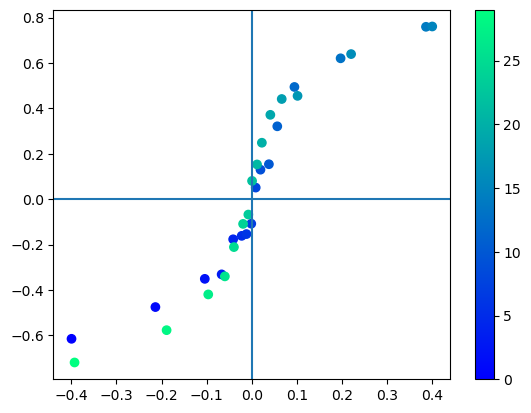

In [310]:
file_path = Path("FILES/HOPG1/Manual_Hysteresis_1/")
manual_hyst(file_path, normalisation=None, plot_xmcd=False)

347046
347047
347048
347049
347050
347051
347052


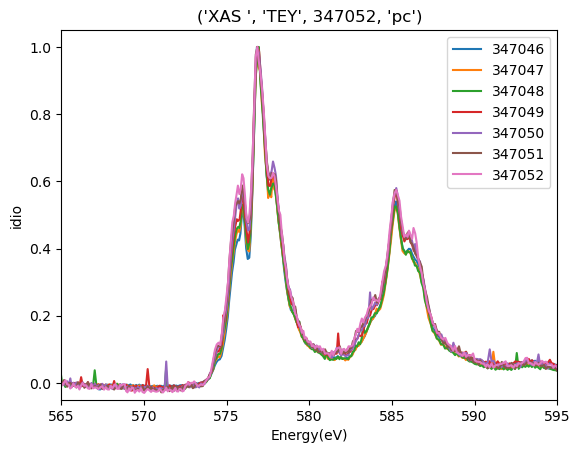

In [37]:
sensor = "TEY"
#sensor = "TFY"damage
directory_path = r"FILES/HOPG1/Checking for beam damage/"
XAS_ﬁle_set=[347046,347047,347048,347049,347050,3427051,347052] #

XMCD = prelimenary_code(di2025-01-30 20:35:53,154 WARN  gda.factory.Finder - Finder could not find an object called 'taper'. At some point, this method will throw an exception instead of returning null!
rectory_path, ﬁle_preﬁx, XAS_ﬁle_set,sensor)

####This line plots all the spectra 2025-01-30 21:11:58,926 INFO  EnergyConsolidationClass:iddrpenergy - delayedSwitchAndMoveEnergy(): iddpol.isBusy()=True
in the given list.
for i in range(0,len(XAS_file_set)):
    XMCD.plot_spectra(XAS_file_set, i, bounds = [[560,590],[-0.05,1.05]], normalisation = 5)

347258
347257
B Field -  0.4005
Max Di - 0.7474092026801038, Max Signal - 1.22175097016475


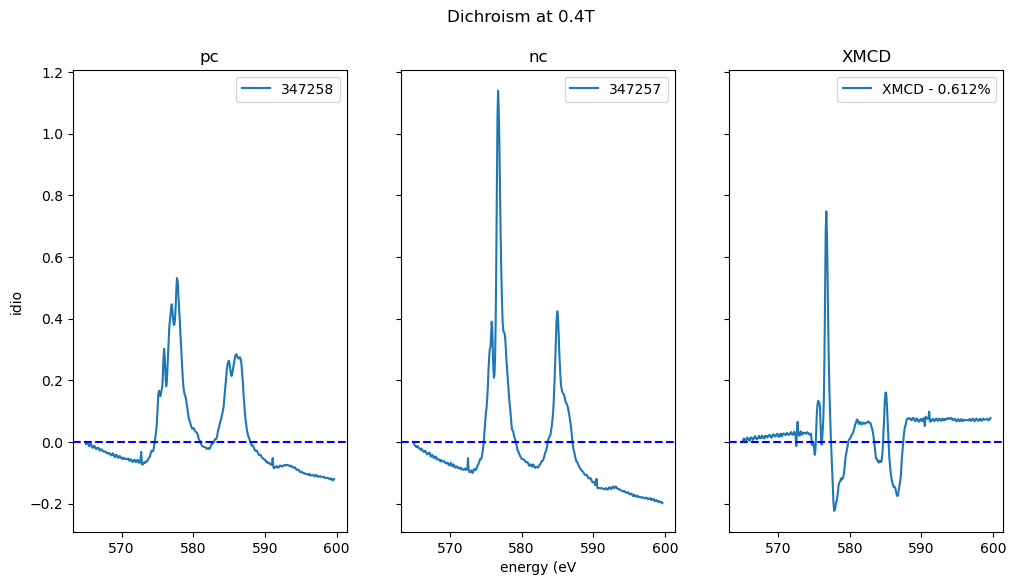

In [207]:
##60deg - 400mT Coercive Field 
sensor = "TEY"
directory_path = r"FILES/HOPG1/XMCD/"
XMCD_ﬁle_Set = (347258,347257)

XMCD = prelimenary_code(directory_path, ﬁle_preﬁx, XMCD_ﬁle_Set,sensor)
energy,dichroism = XMCD.Dichroism(XMCD_ﬁle_Set, normalisation=1) 
2025-01-31 01:50:46,303 INFO  gda.jython.JythonServerStatusHolder - Command Server status: script=RUNNING, scan=RUNNING


In [ ]:
files = ['i06-1-347283.nxs', 'i06-1-347285.nxs', 'i06-1-347286.nxs', 'i06-1-347284.nxs']

26


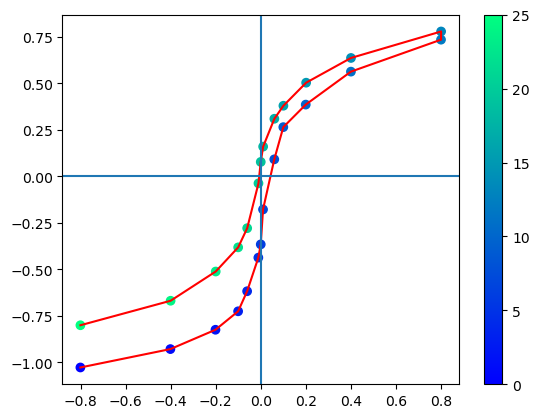

In [355]:
file_path = Path("FILES/HOPG1/Manual_Hysteresis_2/")
manual_hyst(file_path, Yield = "TEY", plot_xmcd = False,normalisation=None)

25


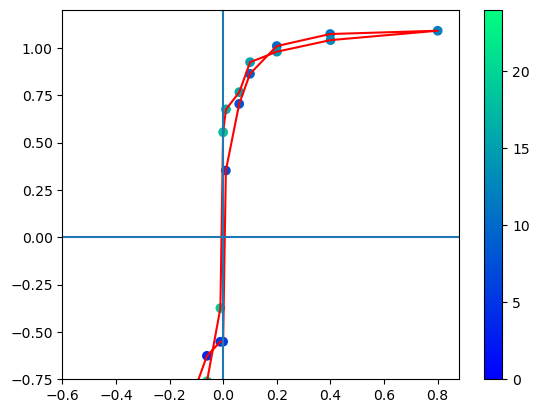

In [399]:
file_path = Path("FILES/HOPG1/Manual_Hysteresis_3/")
curve2 = manual_hyst(file_path, Yield = "TEY", normalisation=None, Label = False, plot_xmcd =False,bounds = [-0.6,-0.75])

26


/tmp/ipykernel_33617/4204131483.py:329: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, [axXAS, axXMCD] = plt.subplots(1,2, sharey=True)


[np.float64(-0.8356375409898871),
 np.float64(-0.7084719184153134),
 np.float64(-0.5889240710395246),
 np.float64(-0.39290930078354763),
 np.float64(-0.41857855498723007),
 np.float64(-0.3018953677888175),
 np.float64(-0.32052577786197056),
 np.float64(-0.15356137194737993),
 np.float64(0.22467402020578323),
 np.float64(0.3078647231221911),
 np.float64(0.6616584776816159),
 np.float64(0.7856905220709373),
 np.float64(0.9144797526645055),
 np.float64(0.9007548595753972),
 np.float64(0.7952143438868021),
 np.float64(0.6342171816286027),
 np.float64(0.3650584734832958),
 np.float64(0.3819180865233918),
 np.float64(0.27040229264507726),
 np.float64(0.22652506835435476),
 np.float64(0.044354545122666775),
 np.float64(-0.10328812315095637),
 np.float64(-0.22844165114553544),
 np.float64(-0.5903705208453763),
 np.float64(-0.7607736199892434),
 np.float64(-0.9057024311373685)]

<Figure size 640x480 with 0 Axes>

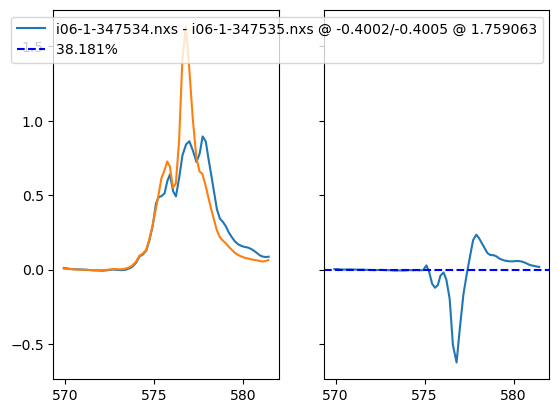

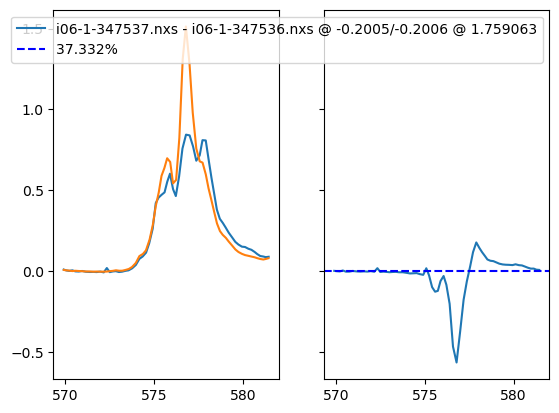

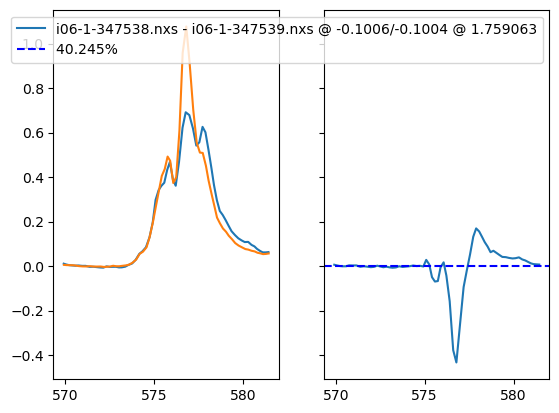

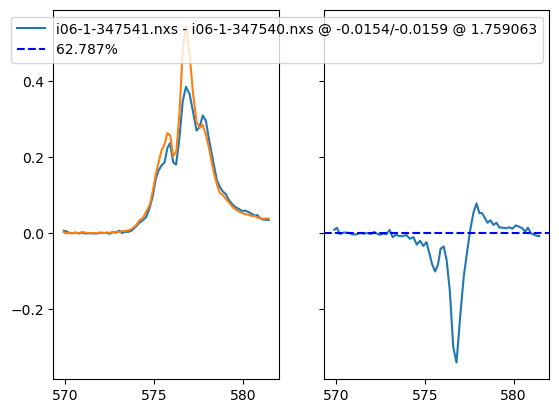

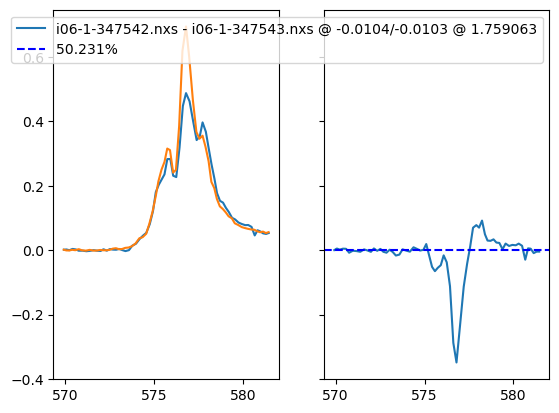

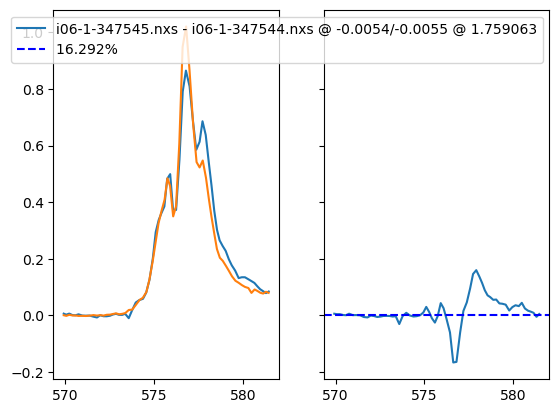

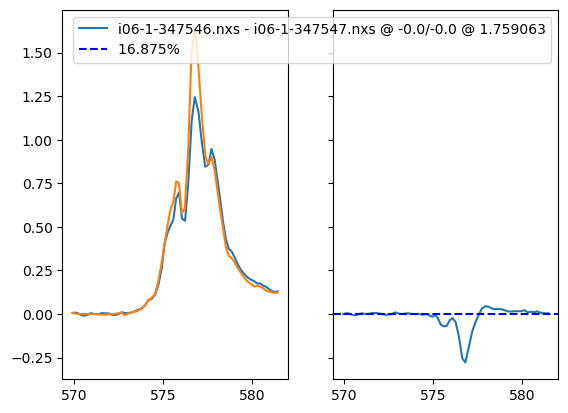

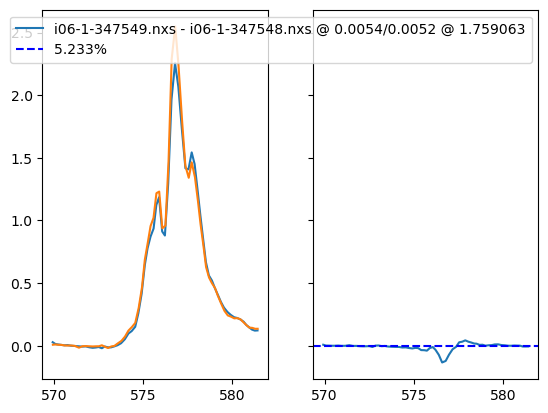

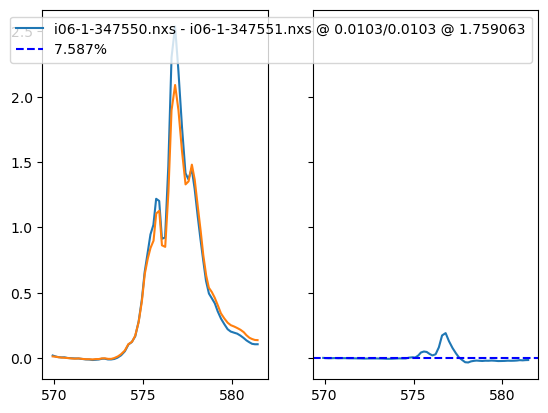

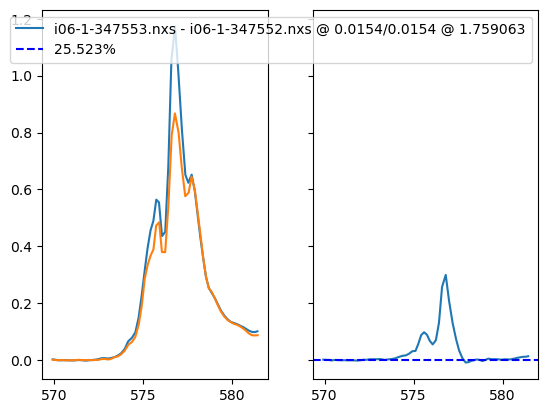

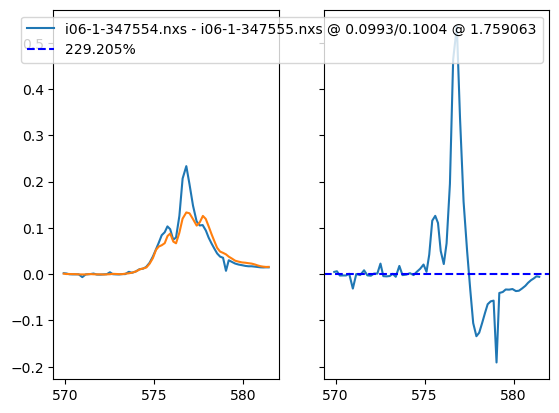

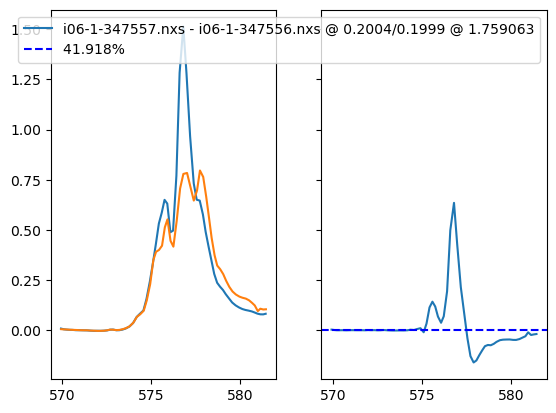

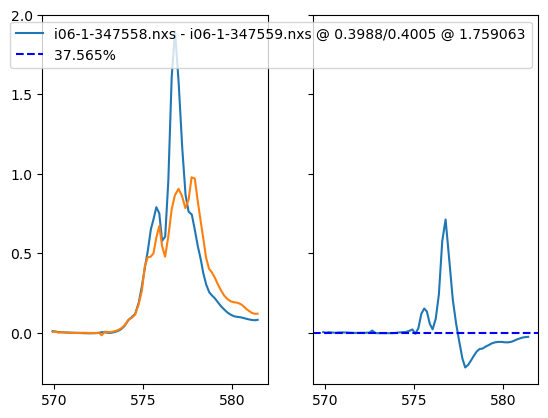

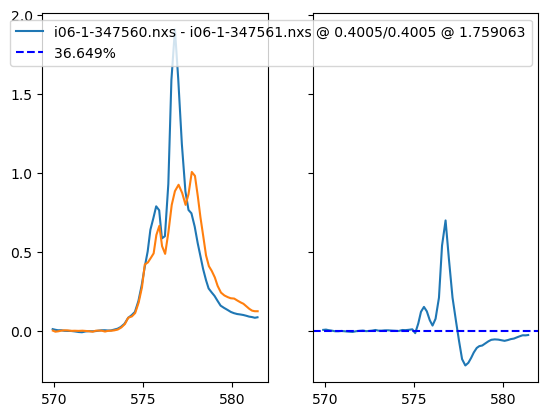

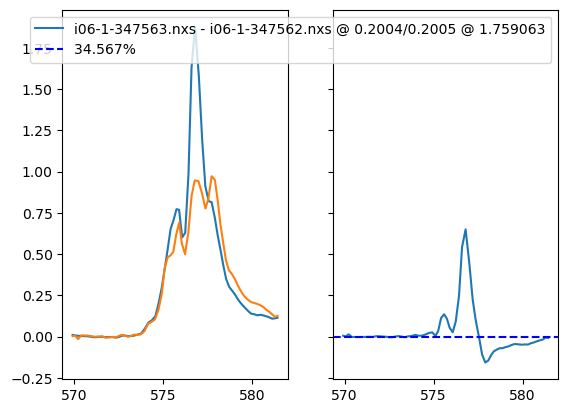

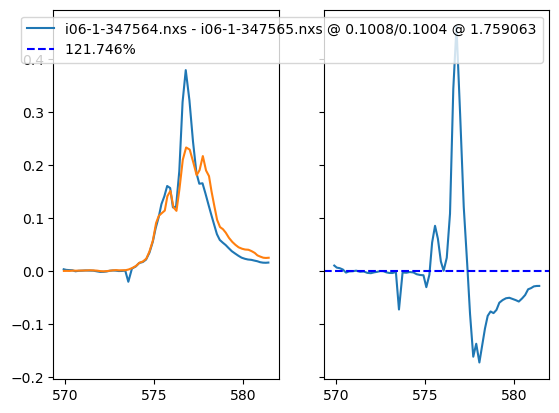

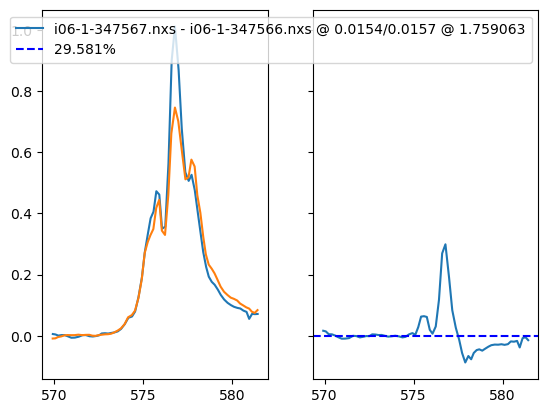

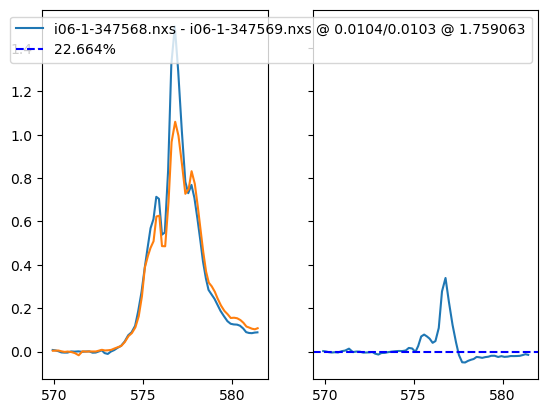

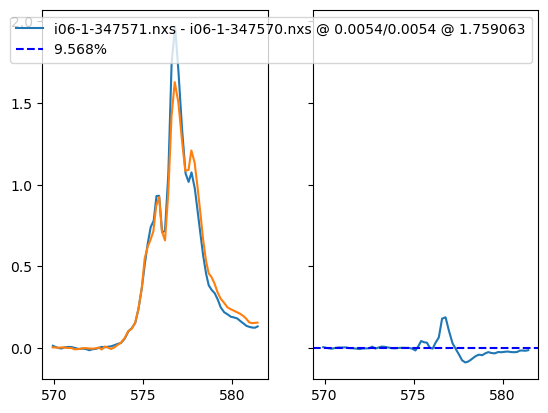

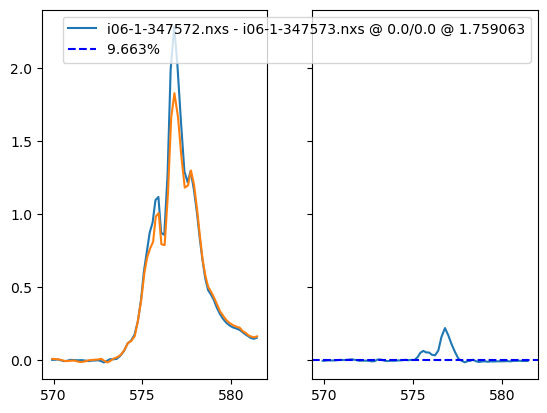

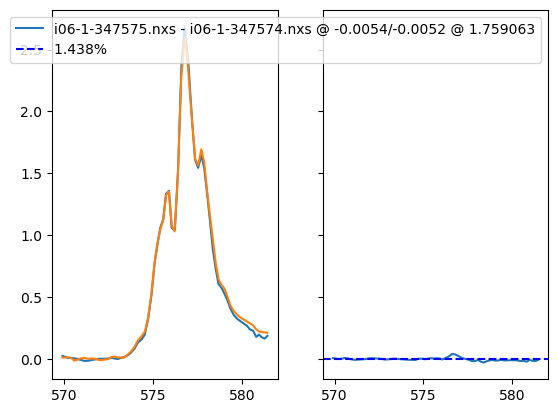

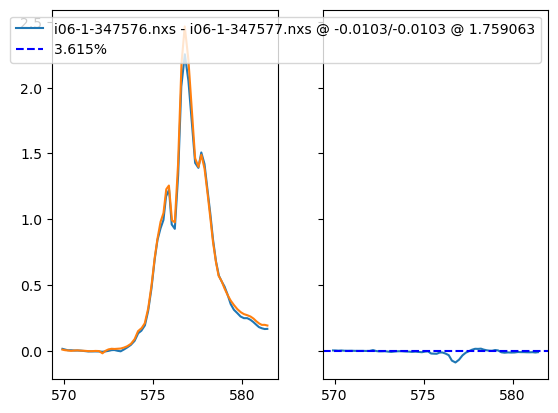

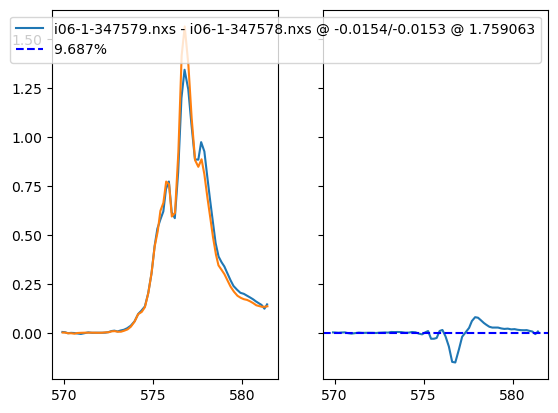

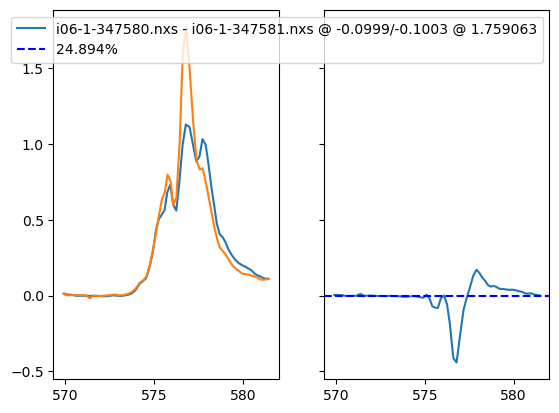

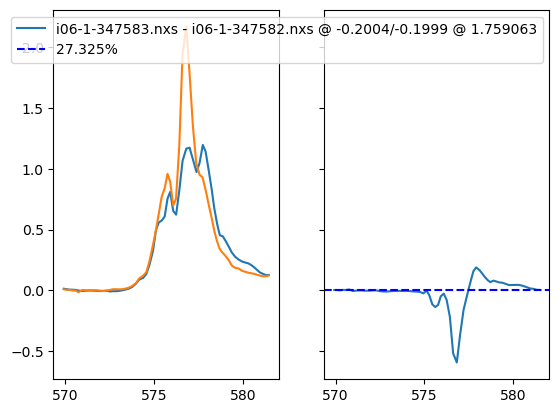

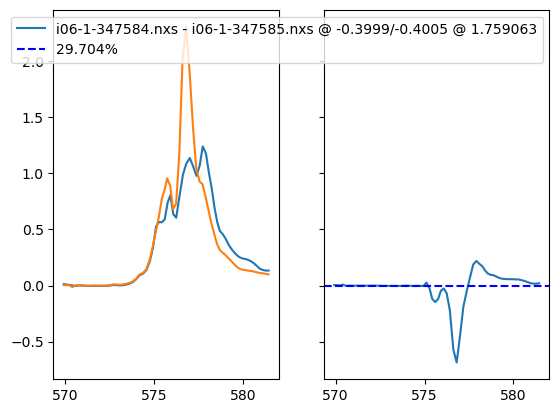

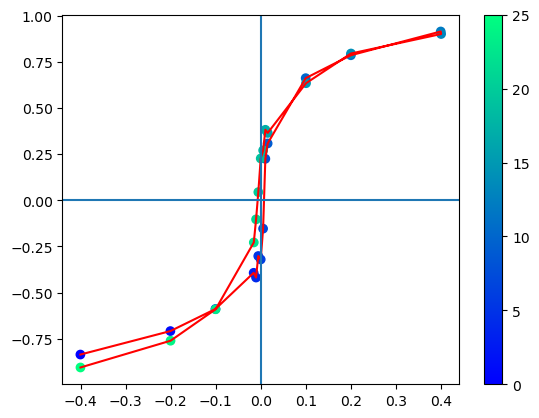

In [443]:
file_path = Path("FILES/HOPG1/Manual_Hysteresis_4/")
manual_hyst(file_path, Yield = "TEY", normalisation=15, Label = False, plot_xmcd =True)

26


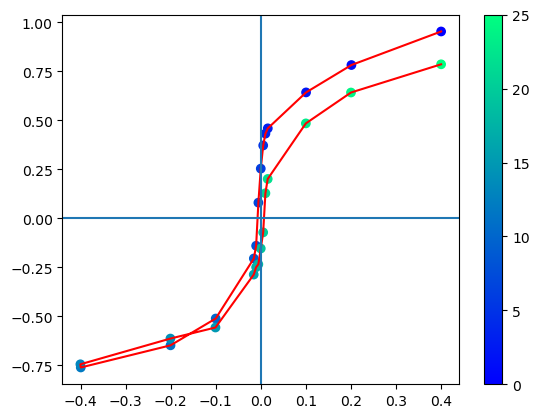

In [405]:
file_path = Path("FILES/HOPG1/Manual_Hysteresis_5/")
curve1 =  manual_hyst(file_path, Yield = "TEY", normalisation=15, Label = False, plot_xmcd =False) #bounds = [(-0.1,0.1),(-0.5,0.5)

347638
347639
B Field -  2.0015
Max Di - 0.3590645961309722, Max Signal - 1.2745373017061765


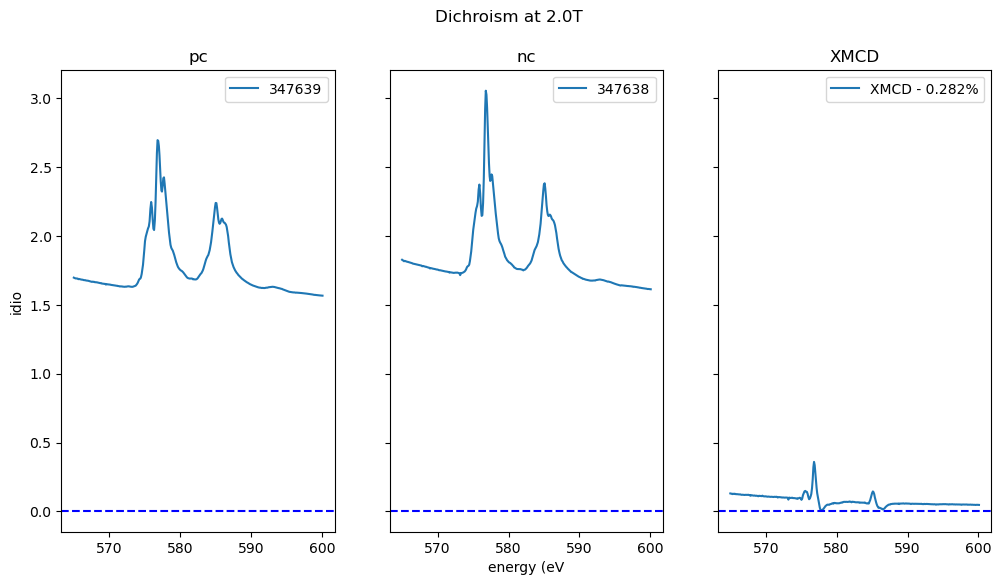

In [342]:
##60deg - 
sensor = "TEY"
directory_path = r"FILES/HOPG1/XMCD/"
XMCD_ﬁle_Set = (347638,347639)

XMCD = prelimenary_code(directory_path, ﬁle_preﬁx, XMCD_ﬁle_Set,sensor)
energy,dichroism = XMCD.Dichroism(XMCD_ﬁle_Set, normalisation=None) 


347640
347641
B Field -  2.0015
Max Di - 1.054049403297955, Max Signal - 1.4873159401455922


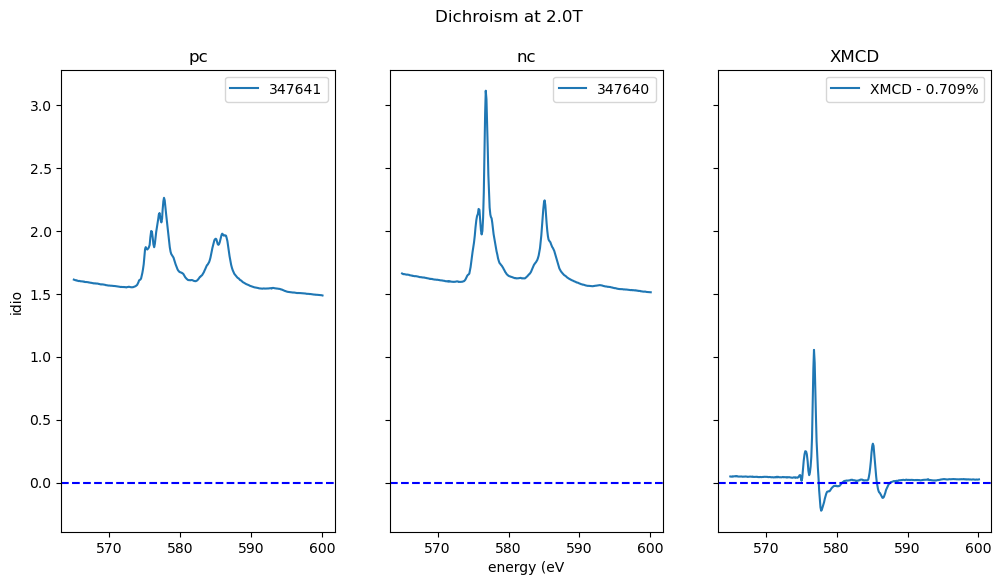

In [343]:
##60deg - 400mT Coercive Field 5.7k
sensor = "TEY"
directory_path = r"FILES/HOPG1/XMCD/"
XMCD_ﬁle_Set = (347640,347641)2025-01-31 01:50:46,303 INFO  gda.jython.JythonServerStatusHolder - Command Server status: script=RUNNING, scan=RUNNING
2025-01-31 01:50:46,303 INFO  gda.jython.JythonServerStatusHolder - Command Server status: script=RUNNING, scan=RUNNING


XMCD = prelimenary_code(directory_path, ﬁle_preﬁx, XMCD_ﬁle_Set,sensor)
energy,dichroism = XMCD.Dichroism(XMCD_ﬁle_Set, normalisation=None) 


347642
347643
B Field -  2.0016
Max Di - 0.8541203809455291, Max Signal - 1.2905646533321482


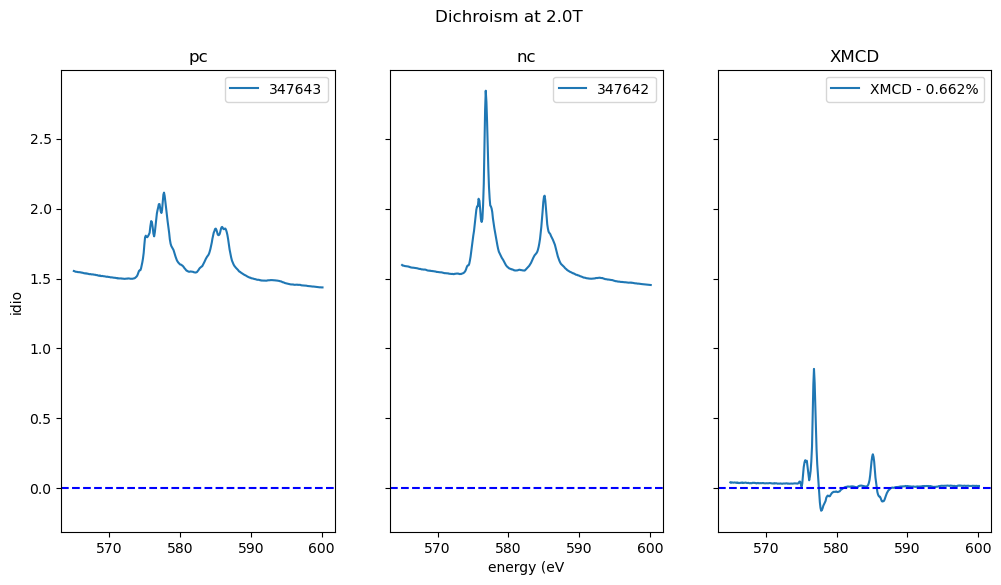

In [344]:
##60deg - 400mT Coercive Field 9.6k
sensor = "TEY"
directory_path = r"FILES/HOPG1/XMCD/"
XMCD_ﬁle_Set = (347642,347643)

XMCD = prelimenary_code(directory_path, ﬁle_preﬁx, XMCD_ﬁle_Set,sensor)
energy,dichroism = XMCD.Dichroism(XMCD_ﬁle_Set, normalisation=None) 


10


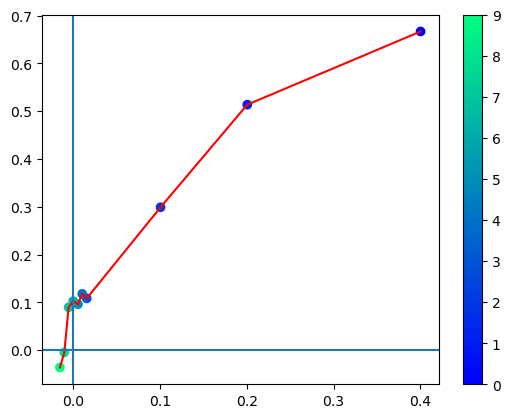

In [353]:
file_path = Path("FILES/HOPG1/Manual_Hysteresis_10k/")
manual_hyst(file_path, Yield = "TEY", normalisation=15, Label = False, plot_xmcd =False)

42


[np.float64(1.0848716097661333),
 np.float64(1.0924618847894978),
 np.float64(1.0840260837894975),
 np.float64(1.0518277324252283),
 np.float64(0.9170600846234186),
 np.float64(0.8172059677070731),
 np.float64(0.6342711520910306),
 np.float64(0.48494914346243106),
 np.float64(0.5085654161265029),
 np.float64(0.4177648222231304),
 np.float64(0.4050294702622658),
 np.float64(0.25998312923045486),
 np.float64(0.004415162089027022),
 np.float64(-0.07851215371552822),
 np.float64(-0.592021456786493),
 np.float64(-0.6416971433969133),
 np.float64(-0.8057461023325047),
 np.float64(-0.997627613080448),
 np.float64(-1.0440806401034677),
 np.float64(-1.0290610561824876),
 np.float64(-1.008007390236686),
 np.float64(-0.9894029189017761),
 np.float64(-0.8794921266074897),
 np.float64(-0.9460974656553971),
 np.float64(-0.8785858019338644),
 np.float64(-0.7032885628446819),
 np.float64(-0.5507747649291913),
 np.float64(-0.40577306176807537),
 np.float64(-0.1785484159400707),
 np.float64(0.1654691886

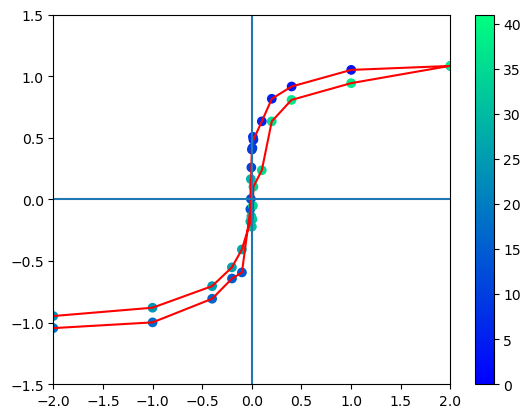

In [442]:
file_path = Path("FILES/HOPG1/Manual_Hysteresis_6/")
manual_hyst(file_path, Yield = "TEY", normalisation=15, Label = False, plot_xmcd =False,bounds = [(-2,2),(-1.5,1.5)])

[np.float64(0.9541082391672528), np.float64(0.7828016503128236), np.float64(0.6430217244814949), np.float64(0.459588527972657), np.float64(0.43244455277728633), np.float64(0.37215843203791393), np.float64(0.2538756453249039), np.float64(0.08010582139044527), np.float64(-0.13991075285832985), np.float64(-0.2049826210723364), np.float64(-0.5115134745056982), np.float64(-0.6484246087498631), np.float64(-0.7614695798001307), np.float64(-0.7451212884448842), np.float64(-0.6137964518360414), np.float64(-0.5574141085647861), np.float64(-0.2871785242639565), np.float64(-0.2494231950297588), np.float64(-0.23470915789688657), np.float64(-0.1540364941641138), np.float64(-0.07171217585785093), np.float64(0.12819791268751027), np.float64(0.20105106663882552), np.float64(0.4848226570608558), np.float64(0.6424392348649606), np.float64(0.786496241999252)]


TypeError: unsupported operand type(s) for /: 'list' and 'int'

35


[np.float64(1.155052257727709),
 np.float64(1.0661338843242458),
 np.float64(0.9067338323750457),
 np.float64(0.7227320576861074),
 np.float64(0.5644157448427437),
 np.float64(0.2913991894204576),
 np.float64(0.250026425148841),
 np.float64(0.2776781190781651),
 np.float64(0.24987852788794046),
 np.float64(0.19064253779592838),
 np.float64(0.12494541905030421),
 np.float64(0.026867175620371817),
 np.float64(-0.44908803962174837),
 np.float64(-0.6660678407218885),
 np.float64(-0.8637397780660814),
 np.float64(-1.0469434149646317),
 np.float64(-1.1238775440739668),
 np.float64(-1.138957732183793),
 np.float64(-1.0397867338787306),
 np.float64(-0.8796868431511364),
 np.float64(-0.6784842694018),
 np.float64(-0.43581443581083),
 np.float64(-0.12427752162095163),
 np.float64(-0.08963777997205521),
 np.float64(-0.06863634282062976),
 np.float64(-0.029146710823588974),
 np.float64(-0.01988577869381132),
 np.float64(0.02240015359164188),
 np.float64(0.02606417145065421),
 np.float64(0.48435511

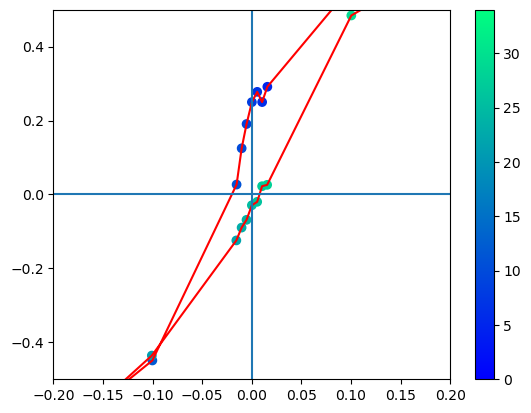

In [447]:
file_path = Path("FILES/HOPG1/Manual_Hysteresis_7/")
manual_hyst(file_path, Yield = "TEY", normalisation=15, Label = False, plot_xmcd =False,bounds = [(-0.2,0.2),(-0.5,0.5)])

34


[np.float64(1.155052257727709),
 np.float64(1.0661338843242458),
 np.float64(0.9067338323750457),
 np.float64(0.7227320576861074),
 np.float64(0.5644157448427437),
 np.float64(0.2913991894204576),
 np.float64(0.250026425148841),
 np.float64(0.2776781190781651),
 np.float64(0.24987852788794046),
 np.float64(0.19064253779592838),
 np.float64(0.12494541905030421),
 np.float64(0.026867175620371817),
 np.float64(-0.44908803962174837),
 np.float64(-0.6660678407218885),
 np.float64(-0.8637397780660814),
 np.float64(-1.0469434149646317),
 np.float64(-1.1238775440739668),
 np.float64(-1.138957732183793),
 np.float64(-1.0397867338787306),
 np.float64(-0.8796868431511364),
 np.float64(-0.6784842694018),
 np.float64(-0.43581443581083),
 np.float64(-0.12427752162095163),
 np.float64(-0.08963777997205521),
 np.float64(-0.06863634282062976),
 np.float64(-0.029146710823588974),
 np.float64(-0.01988577869381132),
 np.float64(0.02240015359164188),
 np.float64(0.02606417145065421),
 np.float64(0.48435511

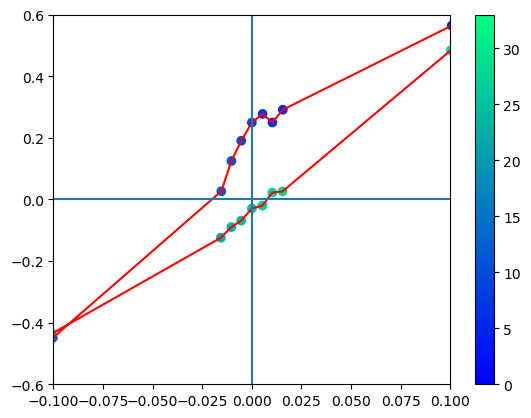

In [429]:
file_path = Path("FILES/HOPG1/Manual_Hysteresis_7/")
manual_hyst(file_path, Yield = "TEY", normalisation=15, Label = False, plot_xmcd =False,bounds = [(-0.1,0.1),(-0.6,0.6)])

347828
347829
B Field -  2.0015
Max Di - 0.8236231280607598, Max Signal - 1.6410656348884658


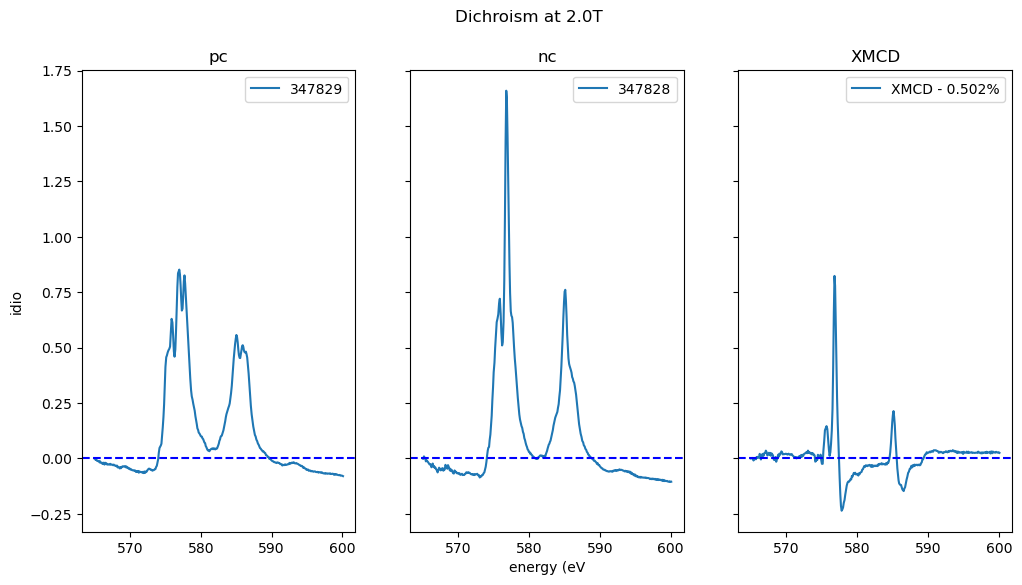

In [432]:
# We have temperature dependence using the PID loop XMCD NI at 20K
sensor = "TEY"
directory_path = r"FILES/HOPG1/XMCD/"
XMCD_ﬁle_Set = (347828,347829)

XMCD = prelimenary_code(directory_path, ﬁle_preﬁx, XMCD_ﬁle_Set,sensor)
energy,dichroism = XMCD.Dichroism(XMCD_ﬁle_Set, normalisation=1) 


347830
347831
B Field -  0.0
Max Di - 0.023499479713827265, Max Signal - 0.6026189139362366


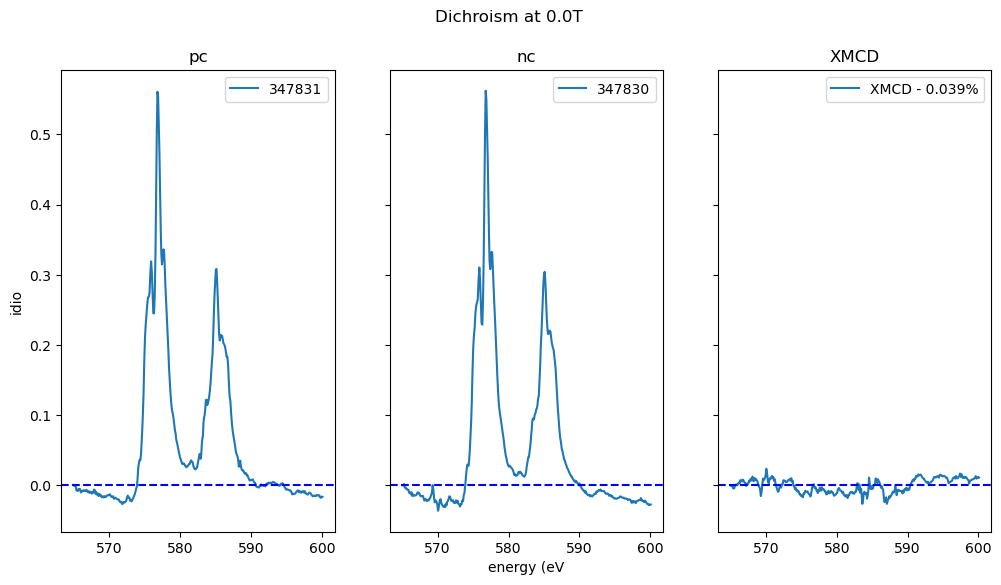

In [433]:
#### Checking for remnants at 20K 0 field NI

sensor = "TEY"
directory_path = r"FILES/HOPG1/XMCD/"
XMCD_ﬁle_Set = (347830,347831)

XMCD = prelimenary_code(directory_path, ﬁle_preﬁx, XMCD_ﬁle_Set,sensor)
energy,dichroism = XMCD.Dichroism(XMCD_ﬁle_Set, normalisation=1) 


347832
347833
B Field -  -2.0015
Max Di - 0.30622566287834485, Max Signal - 1.6961462404253171


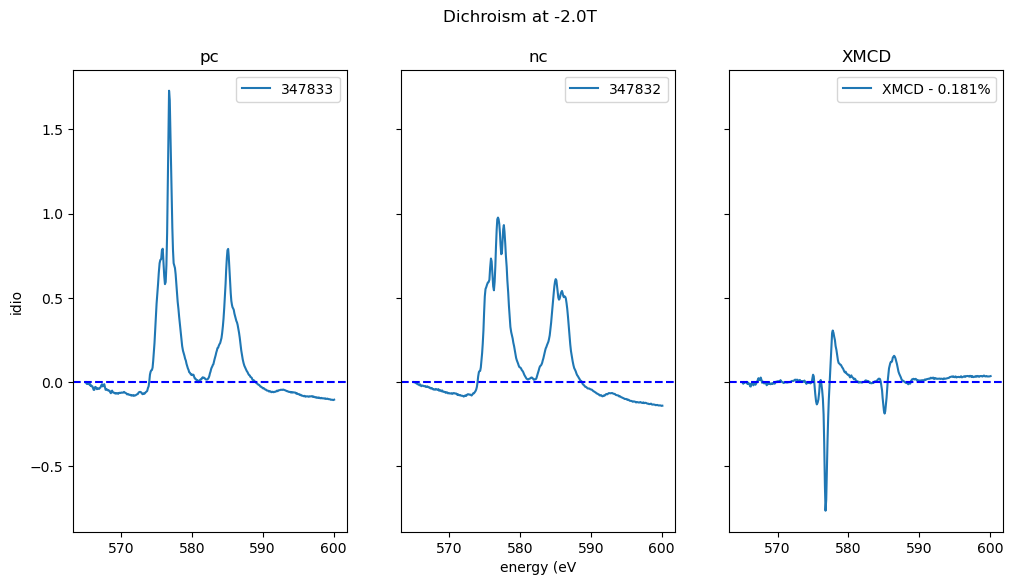

In [434]:
#-2T
sensor = "TEY"
directory_path = r"FILES/HOPG1/XMCD/"
XMCD_ﬁle_Set = (347832,347833)

XMCD = prelimenary_code(directory_path, ﬁle_preﬁx, XMCD_ﬁle_Set,sensor)
energy,dichroism = XMCD.Dichroism(XMCD_ﬁle_Set, normalisation=1) 


347834
347835
B Field -  -0.0
Max Di - 0.023682521537709444, Max Signal - 0.6734691561708687


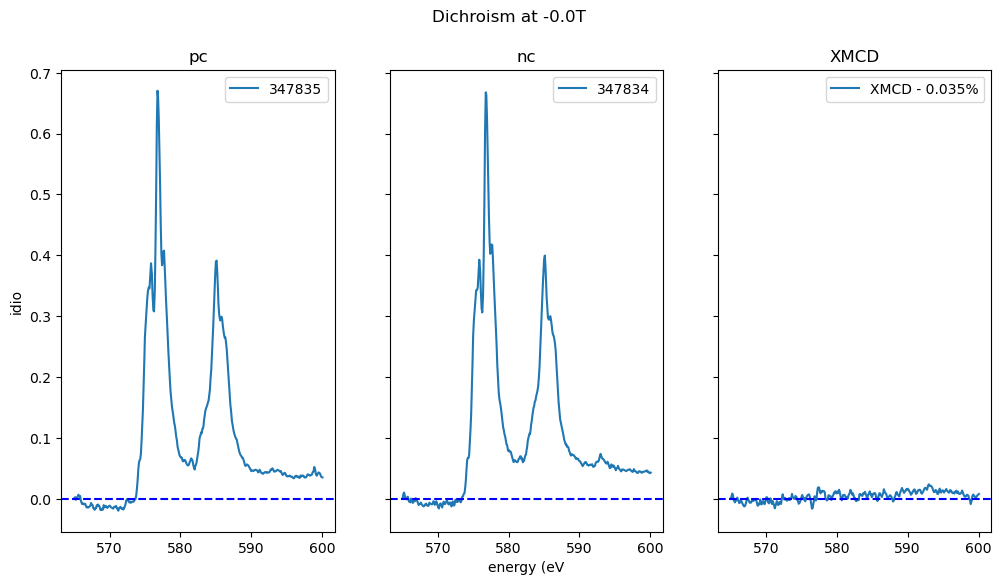

In [436]:
#0T from -2T

sensor = "TEY"
directory_path = r"FILES/HOPG1/XMCD/"
XMCD_ﬁle_Set = (347834,347835)

XMCD = prelimenary_code(directory_path, ﬁle_preﬁx, XMCD_ﬁle_Set,sensor)
energy,dichroism = XMCD.Dichroism(XMCD_ﬁle_Set, normalisation=1) 


347838
347839
B Field -  2.0015
Max Di - 0.9949266913208696, Max Signal - 1.892502242706591


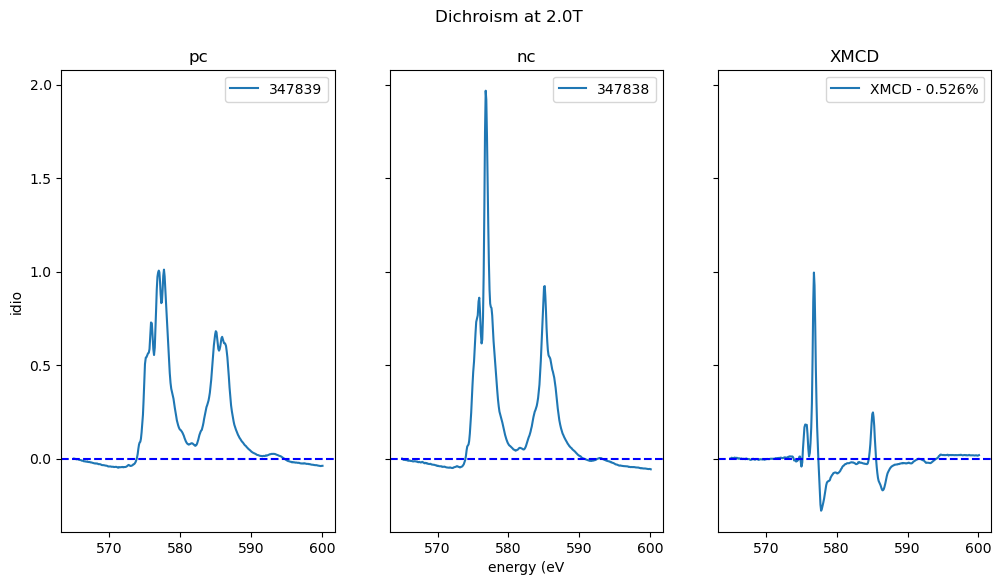

In [437]:
# Back at grazing (60) deg
sensor = "TEY"
directory_path = r"FILES/HOPG1/XMCD/"
XMCD_ﬁle_Set = (347838,347839)

XMCD = prelimenary_code(directory_path, ﬁle_preﬁx, XMCD_ﬁle_Set,sensor)
energy,dichroism = XMCD.Dichroism(XMCD_ﬁle_Set, normalisation=1) 


347840
347841
B Field -  0.0
Max Di - 0.034747358536974415, Max Signal - 1.3164417976804792


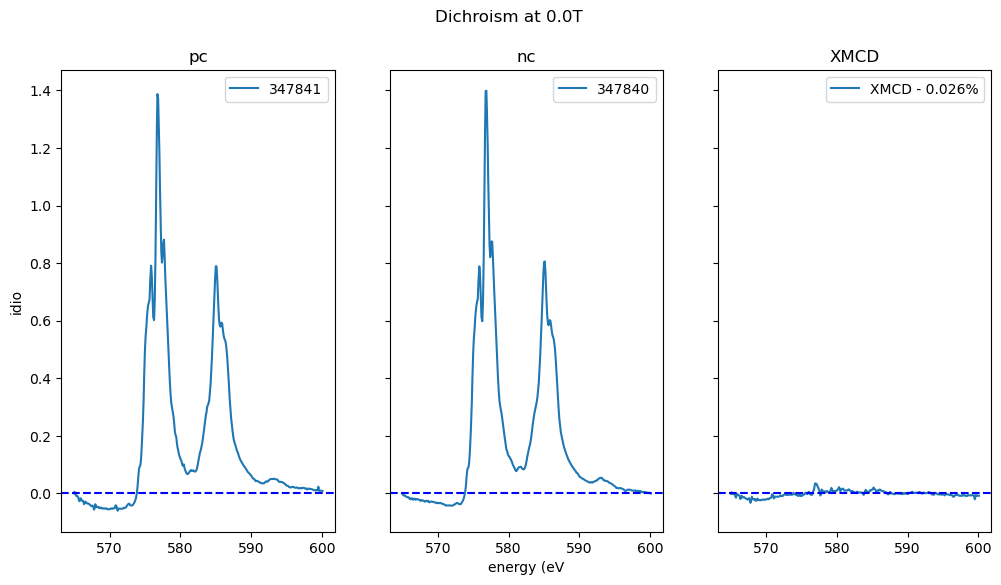

In [438]:
# Back at grazing 20K after a 2T field has been applied
sensor = "TEY"
directory_path = r"FILES/HOPG1/XMCD/"
XMCD_ﬁle_Set = (347840,347841)

XMCD = prelimenary_code(directory_path, ﬁle_preﬁx, XMCD_ﬁle_Set,sensor)
energy,dichroism = XMCD.Dichroism(XMCD_ﬁle_Set, normalisation=1) 


347842
347843
B Field -  -2.0015
Max Di - 0.3190258057846629, Max Signal - 2.0135181103641515


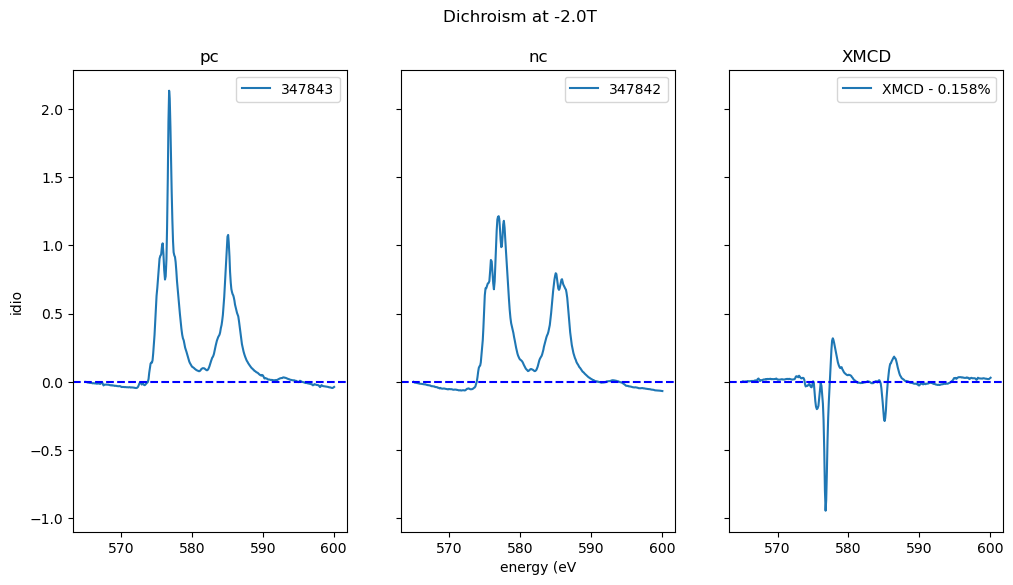

In [439]:
# Back at grazing
sensor = "TEY"
directory_path = r"FILES/HOPG1/XMCD/"
XMCD_ﬁle_Set = (347842,347843)

XMCD = prelimenary_code(directory_path, ﬁle_preﬁx, XMCD_ﬁle_Set,sensor)
energy,dichroism = XMCD.Dichroism(XMCD_ﬁle_Set, normalisation=1) 


347844
347845
B Field -  -0.0
Max Di - 0.0281795416911077, Max Signal - 1.5462140973319958


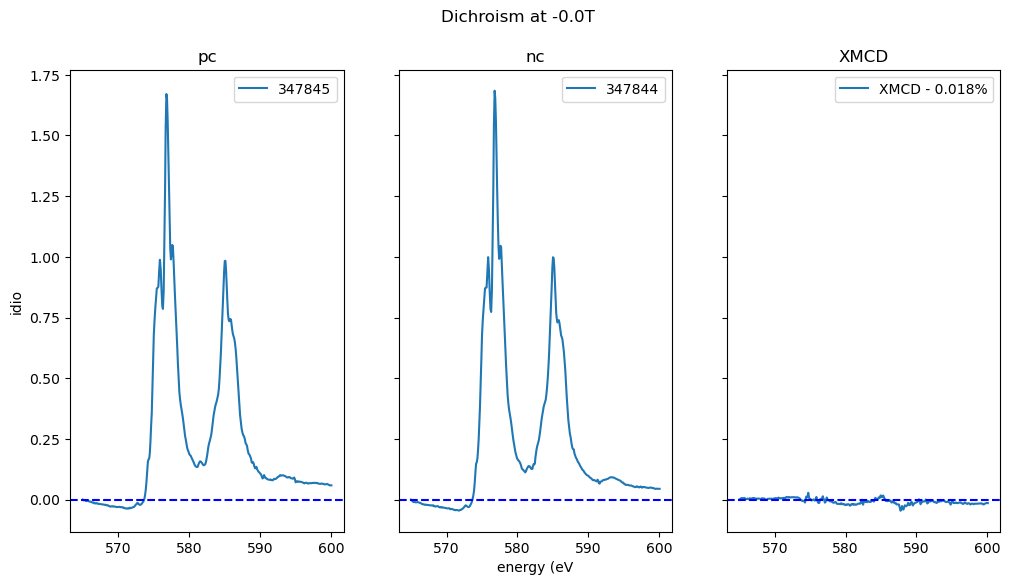

In [440]:
# Back at grazing
sensor = "TEY"
directory_path = r"FILES/HOPG1/XMCD/"
XMCD_ﬁle_Set = (347844,347845)

XMCD = prelimenary_code(directory_path, ﬁle_preﬁx, XMCD_ﬁle_Set,sensor)
energy,dichroism = XMCD.Dichroism(XMCD_ﬁle_Set, normalisation=1) 
